In [16]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
import numpy as np
import optuna
from sklearn.metrics import accuracy_score

In [6]:
training_df=pd.read_csv("../Datasets/training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1


In [9]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

### Dropping highly correlated features

In [10]:
high_correlated_features=['soil_temperature_7_to_28cm','wind_direction_10m','temperature_2m','soil_moisture_28_to_100cm',
                          'soil_moisture_7_to_28cm','soil_temperature_100_to_255cm','soil_temperature_28_to_100cm',
                          'soil_temperature_100_to_255cm','soil_moisture_100_to_255cm']
drop_features=high_correlated_features
X.drop(drop_features,axis=1,inplace=True)
X.shape

(113896, 22)

In [11]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)[0]

### K Fold Cross Validation

In [14]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [17]:
lr = LogisticRegression(max_iter=1000)

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Mean Accuracy = {np.mean(scores):.4f}")

Mean Accuracy = 0.5835


In [23]:
# !pip3 install hyperopt

### Hyperparameter Tuning using hyperopt

In [21]:
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [25]:
space = {
    'C': hp.loguniform('C', -5, 5),
    'max_iter': hp.choice('max_iter', [50, 100, 200, 300]),
    'solver': hp.choice('solver', ['liblinear', 'lbfgs', 'newton-cg']),
    'penalty': hp.choice('penalty', ['l2'])
}
space_mapping={
    'max_iter' : [50,100,200,300],
    'solver':['liblinear', 'lbfgs', 'newton-cg']}
def objective(params):
    model = LogisticRegression(C=params['C'], 
                               max_iter=params['max_iter'], 
                               solver=params['solver'],
                               penalty=params['penalty'], 
                               multi_class='ovr', 
                               random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': STATUS_OK}
trials = Trials()

best = fmin(fn=objective,  
            space=space,
            algo=tpe.suggest,
            max_evals=50, 
            trials=trials)

print("Best hyperparameters found:", best)

100%|███████████████████████████████████████████████| 50/50 [00:33<00:00,  1.48trial/s, best loss: -0.5842405618964004]
Best hyperparameters found: {'C': 0.01667000925475309, 'max_iter': 2, 'penalty': 0, 'solver': 0}


In [51]:
lr = LogisticRegression(C=best['C'],max_iter=space_mapping['max_iter'][best['max_iter']],
                        penalty='l2',solver=space_mapping['solver'][best['solver']])
lr

LogisticRegression(C=0.01667000925475309, max_iter=200, solver='liblinear')

### Model Training

In [52]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=23)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01667000925475309, max_iter=200, solver='liblinear')

In [53]:
y_pred=lr.predict(X_test)
y_scores = lr.predict_proba(X_test)[:, 1]

### Evaluation

In [54]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59     11452
           1       0.59      0.59      0.59     11328

    accuracy                           0.59     22780
   macro avg       0.59      0.59      0.59     22780
weighted avg       0.59      0.59      0.59     22780



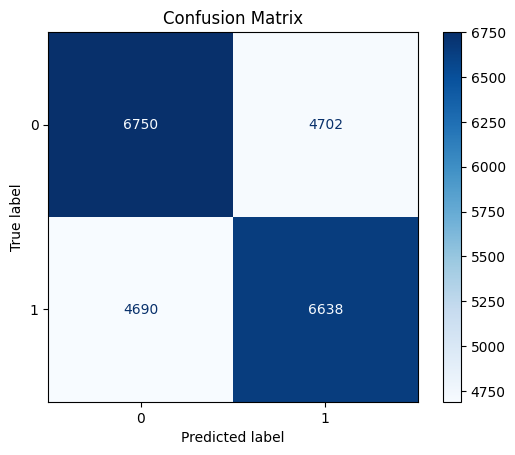

In [55]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.618857645014514


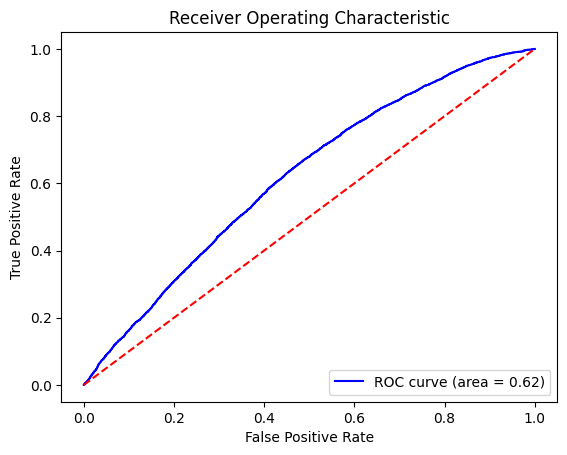

In [56]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()